<a href="https://colab.research.google.com/github/latifurkhan/UROP-Research-Project-2019/blob/master/GPUSelectorFunction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#About the Code
The basic algorithm to trying to solve the question: How to select different GPUs such that it can be more cost efficient than one Tesla v100 GPU that is used for machine learning for web applications. Although this is not a very efficient algorithm is still has starter ideas and methods to base later algorithms on.

# Edits
May 2020: Added new GTX 16 series to the list of gpus available for use

defaultdict(<class 'list'>, {'Inception-v3': [{'cost': 0.5839130434782609, 'gpu': 'GTX 1030', 'time': 0.007391304347826088}, {'cost': 0.35123523093447906, 'gpu': 'GTX 1050', 'time': 0.00322234156820623}, {'cost': 0.39008419083255375, 'gpu': 'GTX 1050TI', 'time': 0.002806361085126286}, {'cost': 0.41005714285714284, 'gpu': 'GTX 1060', 'time': 0.0013714285714285714}, {'cost': 0.3518489865387591, 'gpu': 'GTX 1070', 'time': 0.0009283614420547734}, {'cost': 0.36574639628634253, 'gpu': 'GTX 1070TI', 'time': 0.0007329587099926704}, {'cost': 0.4050490251324242, 'gpu': 'GTX 1080', 'time': 0.0006762087230925279}, {'cost': 0.36984126984126986, 'gpu': 'GTX 1080TI', 'time': 0.0005291005291005291}, {'cost': 0.3137943137943138, 'gpu': 'GTX 1650', 'time': 0.002106002106002106}, {'cost': 0.24785658612626657, 'gpu': 'GTX 1650Super', 'time': 0.001558846453624318}, {'cost': 0.297554347826087, 'gpu': 'GTX 1660', 'time': 0.001358695652173913}, {'cost': 0.2733240501293018, 'gpu': 'GTX 1660Super', 'time': 0.00

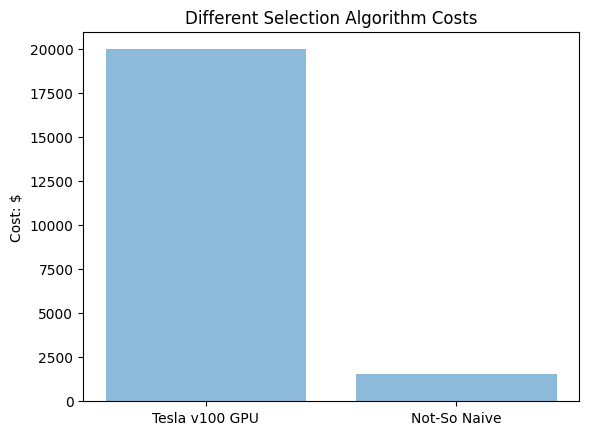

In [0]:
import collections
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np

workloads = [
    { "name": "Inception-v3",  "pct": 250, "gflop": 6.0,    "gb": .17,  "deadline": (0.15497/4) }, # deadline is in seconds
    { "name": "AlexNet",       "pct": 250, "gflop": 0.727,  "gb": .266, "deadline": (0.15497/4)   },
    { "name": "GoogLeNet",     "pct": 250, "gflop": 2.0,    "gb": .077, "deadline": (0.15497/4)  },
    { "name": "SqueezeNet1-0", "pct": 250, "gflop": .837,   "gb": .035, "deadline": (0.15497/4)    }
]
# The GPUs data are taken as FP32 single value operations from this link:
# https://en.wikipedia.org/wiki/List_of_Nvidia_graphics_processing_units
# all values were double-checked with the values given from NVidia website
gpus = {
    "GTX 1030"     : {"gflops": 1127,   "gbs": 23,   "cost": 79.0   },
    "GTX 1050"     : {"gflops": 1862,   "gbs": 84,   "cost": 109.0  },
    "GTX 1050TI"   : {"gflops": 2138,   "gbs": 112,  "cost": 139.0  },
    "GTX 1060"     : {"gflops": 4375,   "gbs": 216,  "cost": 299.0  },
    "GTX 1070"     : {"gflops": 6463,   "gbs": 256,  "cost": 379.0  },
    "GTX 1070TI"   : {"gflops": 8186,   "gbs": 256,  "cost": 499.0  },
    "GTX 1080"     : {"gflops": 8873,   "gbs": 320,  "cost": 599.0  },
    "GTX 1080TI"   : {"gflops": 11340,  "gbs": 484,  "cost": 699.0  },
    "GTX 1650"     : {"gflops": 2849,   "gbs": 128,  "cost": 149    },
    "GTX 1650Super": {"gflops": 3849,   "gbs": 192,  "cost": 159    },
    "GTX 1660"     : {"gflops": 4416,   "gbs": 192,  "cost": 219    },
    "GTX 1660Super": {"gflops": 5027,   "gbs": 336,  "cost": 229    },
    "GTX 1660TI"   : {"gflops": 5437,   "gbs": 288,  "cost": 279    },
    "TITAN X"      : {"gflops": 10974,  "gbs": 480,  "cost": 1200.0 },
    "TITAN XP"     : {"gflops": 11366,  "gbs": 547,  "cost": 1200.0 },
    "TITAN V"      : {"gflops": 12288,  "gbs": 653,  "cost": 2999.0 },
    "RTX 2070"     : {"gflops": 14930,  "gbs": 448,  "cost": 599.0  },
    "RTX 2080"     : {"gflops": 20137,  "gbs": 448,  "cost": 799.0  },
    "RTX 2080TI"   : {"gflops": 26895,  "gbs": 616,  "cost": 1199.0 }
}


'''
Items listed here in case I pull a stupid and delete items in list and need to add them back

    "GTX 1030":   {"gflops": 38,     "gbs": 23,   "cost": 79.0   },
    "GTX 1050":   {"gflops": 1862,   "gbs": 84,   "cost": 109.0  },
    "GTX 1050TI": {"gflops": 2138,   "gbs": 112,  "cost": 139.0  },
    "GTX 1060":   {"gflops": 4375,   "gbs": 216,  "cost": 299.0  },
    "GTX 1070":   {"gflops": 6463,   "gbs": 256,  "cost": 379.0  },
    "GTX 1070TI": {"gflops": 8186,   "gbs": 256,  "cost": 499.0  },
    "GTX 1080":   {"gflops": 8873,   "gbs": 320,  "cost": 599.0  },
    "GTX 1080TI": {"gflops": 11340,  "gbs": 484,  "cost": 699.0  },
    "TITAN X":    {"gflops": 10974,  "gbs": 480,  "cost": 1200.0 },
    "TITAN XP":   {"gflops": 11366,  "gbs": 547,  "cost": 1200.0 },
    "TITAN V":    {"gflops": 12288,  "gbs": 653,  "cost": 2999.0 },
    "RTX 2070":   {"gflops": 14930,  "gbs": 448,  "cost": 599.0  },
    "RTX 2080":   {"gflops": 20137,  "gbs": 448,  "cost": 799.0  },
    "RTX 2080TI": {"gflops": 26895,  "gbs": 616,  "cost": 1199.0 }


'''


# Goal: minimize cost while meeting the deadline
# Assume a very large number of each workload

# key: workload ID, value: [ {gpu_name, cost}]
gpu_preferences = collections.defaultdict(list)



for workload in workloads:
    for gpu_name, gpu in gpus.items():
        compute_time = workload["gflop"] / gpu["gflops"]
        mem_time     = workload["gb"] / gpu["gbs"]
        time = max(compute_time, mem_time)
        if time > workload["deadline"]:
            # We can't use this GPU
            continue
            
        # Model cost as GPU dollars * seconds needs to be used
        cost = gpu["cost"] * time
        
        gpu_preferences[workload["name"]].append({
            "cost": cost, 
            "gpu": gpu_name, 
            "time": time})
print(gpu_preferences)
print([x[2] for x in gpu_preferences.values()])


# Buy 1 more GPU, most constrained - only one option, otherwise highest minimum cost, or longest minimum time among workloads
# Any time with an option, pick cheaper one
#
# pct -> actual workloads
# When we buy GPU, 1st priority goes to workload we bought it for, then use it for next best thing.

workload_pool = []
for workload in workloads:
    for i in range(workload["pct"]):
        workload_pool.append(workload["name"])
print(workload_pool)

# Our job: buy some GPUs, get the work done, spend as little as possible

def dumb_selector(works):
    # Buy 1 GPU per workload
    total_cost = 0
    gpu_selection = [] 
    for workload in works:
        
        # Find the lowest cost GPU for the workload
        lowest_cost = sorted(gpu_preferences[workload], key=lambda x: x["cost"])[0]
        
        # Append that to gpu_selection
        gpu_selection.append(lowest_cost["gpu"])
        
        # Add the GPU's price to total_cost
        total_cost += gpus[lowest_cost["gpu"]]["cost"]
        
        
    print(gpu_selection)
    return {
        "cost": total_cost,
        "selection": gpu_selection
    }

''' 

USE THIS FOR BETTER SMART SELECTOR
I THINK THIS CAN DO BETTER THAN THE ORIGINAL SMART SELECTOR FOR REDUCING THE COST
 ______________________________________________________________________________________
|                                                                                      |
|  Compute the memtime for the more dominant thing that the workload                   | 
|  once the memtime dominance is found --> find the cost effective GPU for the first   |
|  workload that comes up.                                                             |
|                                                                                      |
| Copy the array so you can remove (rm) the workload from the copy                     |
|                                                                                      |
|  Once that happens, make var for time to count the time until deadline               |
|  # while time <= deadline:                                                           |
|        check next workload for the amount of time it will take                       |
|         if (time + work_time) < deadline:                                            | 
|             rm the workload from arr copy and add the GPU selection to the list      |
|             i += 1                                                                   |
|                                                                                      |
|    go to the next part of the workload list                                          |
|    continue through the original while loop until all the workloads are done...      |
|                                                                                      |
|                                                                                      |
|                                                                                      |
|                                                                                      |
|  * Make sure that you have GPU workload selections rather than random workload       |
|    array at the top                                                                  |
|______________________________________________________________________________________| 
'''    

wrkld = len(workload_pool)

def give_work_num(i):
    
    if workload_pool[i] == "Inception-v3":
        work_num = 0
    elif workload_pool[i] == "Alexnet":
        work_num = 1
    elif workload_pool[i] == "GoogLeNet":
        work_num = 2
    else:
        work_num = 3
        
    return work_num    
    
def smarter_selector(ws):
    
    # Buy 1 GPU per workload it can complete in a set deadline
    total_cost = 0
    gpu_selected = []
    
    
    selected_cost = 0
    i = 0
    # wrklds is the length of ws (the workload pool)
    # i goes through the length of ws and ws[i] is the workload at a certain index
    # i should increase depending on if there are other 
    while i < wrkld:
        
        # Finds the lowest cost GPU for the workload
        lowest_cost = sorted(gpu_preferences[ws[(i)]], key = lambda x: x["cost"])[0]
        
        
        # Appends the GPU to the end of the selection
        gpu_selected.append(lowest_cost["gpu"])
        
        #Assigns values for gpu / workloads "gbs" & "worklaod" to compute and find dominant time
        gpu_gflop = gpus[lowest_cost["gpu"]]["gflops"]
        gpu_gbs = gpus[lowest_cost["gpu"]]["gbs"]
        
        work_num = give_work_num(i)
        
        workload_gflop = workloads[work_num]["gflop"] 
        workload_gb = workloads[work_num]['gb']
        
        
        comp_time = workload_gflop / gpu_gflop
        memory_time = workload_gb / gpu_gbs
        time_taken = max(comp_time, memory_time)
        
        # If there is still time remaining from the original workload deadline...
        #     if the next workload can be completed... go to the next workload after that
        #     do this until the first workload deadline is met.
        
        time_used = time_taken
        selected_cost += gpus[lowest_cost["gpu"]]["cost"]
        
        current_load = work_num
        while time_used <  workloads[current_load]["deadline"]:
            if i >= wrkld:
                break
            else:
                new_work_num = give_work_num((wrkld - i) - 1)
                    
                next_work_time = max((workloads[new_work_num]["gflop"] / gpu_gflop), 
                                     (workloads[new_work_num]['gb'] / gpu_gbs))             
                if (time_used + next_work_time) < workloads[work_num]["deadline"]:
                    i += 2
                    time_used += next_work_time
                else: 
                    i+= 1
                    break
            if i >= wrkld:
                break

    
    return {
        "cost": selected_cost,
        "selection": gpu_selected
    }
            
#dumb_cost = dumb_selector(workload_pool)["cost"]
smarter_cost = smarter_selector(workload_pool)["cost"]
print(smarter_selector(workload_pool)["selection"])
print(dumb_selector(workload_pool)["selection"])
dumb_cost = dumb_selector(workload_pool)["cost"]
print(len(dumb_selector(workload_pool)["selection"]))
print('$',dumb_cost)
print(len(smarter_selector(workload_pool)["selection"]))
print('$ 20000.0')
print("$",smarter_cost)
gpu_list = []
all_list = []
for i in smarter_selector(workload_pool)["selection"]:
    all_list.append(i)
    if i not in gpu_list:
        gpu_list.append(i)
        
print('Types of GPUs Needed',gpu_list)
print("List of all GPUs:" , all_list)

#other_list = []
#for i in dumb_selector(workload_pool)["selection"]:
 #   if i not in other_list:
 #       other_list.append(i)
#print("Dumb Selection: ", other_list)
    


# Plots the cost difference for the different selector algorithms 
objects = ('Tesla v100 GPU', 'Not-So Naive')
y_pos = np.arange(len(objects))
performance = [20000, smarter_cost]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Cost: $')
plt.title('Different Selection Algorithm Costs')

plt.show()